In [1]:
import numpy as np
from numpy import argmax, asarray, copy, diff, log, mean
from numpy.fft import rfft
from scipy.signal import correlate, decimate
from scipy.signal.windows import kaiser
import math;
import wavio
import IPython
from IPython.display import Audio
import matplotlib.pyplot as plt

/Users/xrickliao/miniconda/envs/tfenv1/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_wav(wavsig=None, plotsize:list=None, title:str=None):
    if plotsize != None:
        f = plt.figure()
        f.set_figwidth(plotsize[0])
        f.set_figheight(plotsize[1])
    if title != None:
        plt.title=title;
    plt.plot(wavsig)
    plt.ylabel("Amplitude");
    plt.xlabel("Time");
    plt.show()

### frequency estimation algorithms

In [3]:
class freq_estimate:
    
    @staticmethod
    def freq_from_crossings(signal, fs, interp='linear'):
        """
        Estimate frequency by counting zero crossings
    
        Works well for long low-noise sines, square, triangle, etc.
    
        Pros: Fast, accurate (increasing with signal length).
    
        Cons: Doesn't work if there are multiple zero crossings per cycle,
        low-frequency baseline shift, noise, inharmonicity, etc.
        """
        signal = asarray(signal) + 0.0
    
        # Find all indices right before a rising-edge zero crossing
        indices = find((signal[1:] >= 0) & (signal[:-1] < 0))
    
        if interp == 'linear':
            # More accurate, using linear interpolation to find intersample
            # zero-crossings (Measures 1000.000129 Hz for 1000 Hz, for instance)
            crossings = [i - signal[i] / (signal[i+1] - signal[i])
                         for i in indices]
        elif interp == 'none' or interp is None:
            # Naive (Measures 1000.185 Hz for 1000 Hz, for instance)
            crossings = indices
        else:
            raise ValueError('Interpolation method not understood')
    
            # TODO: Some other interpolation based on neighboring points might be
            # better.  Spline, cubic, whatever  Can pass it a function?
        return fs / mean(diff(crossings))
        
    @staticmethod
    def freq_from_fft(signal, fs):
        """
        Estimate frequency from peak of FFT
    
        Pros: Accurate, usually even more so than zero crossing counter
        (1000.000004 Hz for 1000 Hz, for instance).  Due to parabolic
        interpolation being a very good fit for windowed log FFT peaks?
        https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
        Accuracy also increases with signal length
    
        Cons: Doesn't find the right value if harmonics are stronger than
        fundamental, which is common.
        """
        signal = asarray(signal)
    
        N = len(signal)
    
        # Compute Fourier transform of windowed signal
        windowed = signal * kaiser(N, 100)
        f = rfft(windowed,)
    
        # Find the peak and interpolate to get a more accurate peak
        i_peak = argmax(abs(f))  # Just use this value for less-accurate result
        i_interp = parabolic(log(abs(f)), i_peak)[0]
    
        # Convert to equivalent frequency
        return fs * i_interp / N  # Hz
        
    @staticmethod
    def freq_from_autocorr(signal, fs):
        """
        Estimate frequency using autocorrelation
    
        Pros: Best method for finding the true fundamental of any repeating wave,
        even with strong harmonics or completely missing fundamental
    
        Cons: Not as accurate, doesn't find fundamental for inharmonic things like
        musical instruments, this implementation has trouble with finding the true
        peak
        """
        signal = asarray(signal) + 0.0
    
        # Calculate autocorrelation, and throw away the negative lags
        signal -= mean(signal)  # Remove DC offset
        corr = correlate(signal, signal, mode='full')
        corr = corr[len(corr)//2:]
    
        # Find the first valley in the autocorrelation
        d = diff(corr)
        start = find(d > 0)[0]
    
        # Find the next peak after the low point (other than 0 lag).  This bit is
        # not reliable for long signals, due to the desired peak occurring between
        # samples, and other peaks appearing higher.
        i_peak = argmax(corr[start:]) + start
        i_interp = parabolic(corr, i_peak)[0]
        return fs / i_interp
        
    @staticmethod
    def freq_from_hps(signal, fs):
        """
        Estimate frequency using harmonic product spectrum
    
        Low frequency noise piles up and overwhelms the desired peaks
    
        Doesn't work well if signal doesn't have harmonics
        """
        signal = asarray(signal) + 0.0
    
        N = len(signal)
        signal -= mean(signal)  # Remove DC offset
    
        # Compute Fourier transform of windowed signal
        windowed = signal * kaiser(N, 100)
    
        # Get spectrum
        X = log(abs(rfft(windowed)))
    
        # Remove mean of spectrum (so sum is not increasingly offset
        # only in overlap region)
        X -= mean(X)
    
        # Downsample sum logs of spectra instead of multiplying
        hps = copy(X)
        for h in range(2, 9):  # TODO: choose a smarter upper limit
            dec = decimate(X, h, zero_phase=True)
            hps[:len(dec)] += dec
    
        # Find the peak and interpolate to get a more accurate peak
        i_peak = argmax(hps[:len(dec)])
        i_interp = parabolic(hps, i_peak)[0]
    
        # Convert to equivalent frequency
        return fs * i_interp / N  # Hz

### calcuation functions for sound properties

In [4]:
def find(condition):
    "Return the indices where ravel(condition) is true"
    res, = np.nonzero(np.ravel(condition))
    return res
    
def rms_flat(a):
    """
    Return the root mean square of all the elements of *a*, flattened out.
    """
    return np.sqrt(np.mean(np.absolute(a)**2))

def dB(q):
    """
    Return the level of a field quantity in decibels.
    """
    return 20 * np.log10(q)

def parabolic(f, x):
    """
    Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.

    f is a vector and x is an index for that vector.

    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.

    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.

    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]

    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
    """
    if int(x) != x:
        raise ValueError('x must be an integer sample index')
    else:
        x = int(x)
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def parabolic_polyfit(f, x, n):
    """
    Use the built-in polyfit() function to find the peak of a parabola

    f is a vector and x is an index for that vector.

    n is the number of samples of the curve used to fit the parabola.
    """
    a, b, c = np.polyfit(np.arange(x-n//2, x+n//2+1), f[x-n//2:x+n//2+1], 2)
    xv = -0.5 * b/a
    yv = a * xv**2 + b * xv + c
    return (xv, yv)

### DFT implementation

In [ ]:
# ref:https://towardsdatascience.com/learn-discrete-fourier-transform-dft-9f7a2df4bfe9#:~:text=The%20output%20of%20the%20DFT,contains%20the%20negative%20frequency%20terms.
# Build a function that calculates the discrete Fourier transform
def DFT(signal):
  # Number of samples, 100 samples in our example
  N = len(signal)
  # The samples from 0 to N-1, [0, 1, 2, ..., 199] in our example
  n = np.arange(N)
  # Generate the frequencies, [[0], [1], [2], ..., [199]] in our example
  k = n.reshape((N,1))
  # e is a matrix of complex numbers with a shape of (N, N), (200, 200) in our example
  e = np.exp(-2j * np.pi * k * n / N)
  # dft is a matrix of complex numbers with a shape of (N,), (200,) in our example
  dft = np.dot(e,signal)
  return dft


### endpoint detection algorithms

In [5]:
def endpoint_detection1(src_signal=None, test_seg_len=2000, threshod=500):
    src_signal_len = len(src_signal)
    current_volume_sum = float(0);
    loopnum = (src_signal_len // test_seg_len)-1; #consider drop out the remaining part
    detect_value_list = [];
    detected_pos = 0;
    for i in range(loopnum):
        start_pos = i*test_seg_len;
        end_pos = (i+1)*test_seg_len;
        test_seg = src_signal[start_pos:end_pos];
        # energy = int(-(np.sqrt(np.mean(test_seg^2))));##-(np.sqrt(np.mean(test_seg**2)));
        # print(type(energy))
        energy = -audioop.rms(test_seg, 2)
        # print(type(energy))
        energy_bytes = bytes([energy & 0xFF, (energy >> 8) & 0xFF]);# shift energy right 8 bits and put it in high positions
        print(f"len of src_sig is {len(test_seg)}, len of energy_bytes:{len(energy_bytes)}")
        debiased_energy = audioop.rms(audioop.add(test_seg, energy_bytes * len(test_seg), 2), 2)
        if debiased_energy > threshod:
            detected_pos = start_pos;
        detect_value_list.append(debiased_energy);
    return detect_value_list, detected_pos

### detection algorithms

In [26]:
def detectAudio(signal=None, sr=None, wanted_freq=None, magthreshold=None, freqthreshold=None, freq_func=None):
    testFreq = freq_func(signal, sr);#freq_estimate.freq_from_fft(signal, sr);
    print(f"testFreq calculated:{testFreq}")
    diff_freq = np.abs(int(np.abs(wanted_freq)-np.abs(testFreq)));
    print(f"diff_freq calculated:{diff_freq}")
    
    sig_len = len(signal);
    window = [0] * sig_len;
    # signal = np.float64(signal);
    i = 0;
    for x in signal:
        window[i] = np.float64(x) * (0.54 - 0.46*math.cos(2*math.pi*np.float64(i)/np.float64(sig_len-1)));
        i += 1;
    window = np.asarray(window, dtype=np.float64);
    print(f"lenght of window:{len(window)}")
    fftData = np.fft.rfft(window,1024);
    print(f"length of fftData:{len(fftData)}")
    fftData_re = np.real(fftData);
    fftData_im = np.imag(fftData);
    targetIndex =  int(np.float64(len(fftData_re)) * np.float64(testFreq) / np.float64(sr));
    # magnitude = np.sqrt(fftData_re^2 + fftData_im^2);
#     magnitude = np.absolute(np.complex128(fftData_re[targetIndex]));#work
    magnitude = np.absolute(np.complex128(fftData[targetIndex]));
    if diff_freq < freqthreshold:
        if magnitude > magthreshold:
            print("Wanted Frequencey detected:{}Hz and magnitude: {}\n".format(testFreq, magnitude));
        else:
            print("Wanted Frequencey detected:{}Hz but no significant magnitude: {}\n".format(testFreq, magnitude));
            
    else:
        print(f"wanted frequency:{wanted_freq} is not found, found frequency:{testFreq} and magnitude is {magnitude}");
        # print("\rNo significant magnitude({}) at {}Hz\n".format(magnitude, testFreq));

    # print(f"wanted frequency:{wanted_freq} is not found, found frequency:{testFreq}");

In [27]:
test_beep1 = "./dataset/raw/wanted_beep_files/beep_clear_clip_01_22K.wav"
_beep_obj1 = wavio.read(test_beep1);
# print(f"rate of w:{w.rate}");
# print(f"rate of w:{w.sampwidth}");
# print(f"rate of w:{w.data.dtype}");
_beep_sig1 = _beep_obj1.data.T[0];
print(f"{test_beep1} loaded.");

./dataset/raw/wanted_beep_files/beep_clear_clip_01_22K.wav loaded.


In [28]:
test_beep2 = "./dataset/raw/wanted_beep_files/beep_with_whitenoise_clip_01_22K.wav";
_beep_obj2 = wavio.read(test_beep2);
_beep_sig2 = _beep_obj2.data.T[0];
print(f"{test_beep2} loaded.");

./dataset/raw/wanted_beep_files/beep_with_whitenoise_clip_01_22K.wav loaded.


In [29]:
n_wav = "./dataset/raw/neg_test_files/neg_beep_clear_clip_01_22K.wav";
nw = wavio.read(n_wav);
n_sig = nw.data.T[0];
print(f"{n_wav} loaded.");

./dataset/raw/neg_test_files/neg_beep_clear_clip_01_22K.wav loaded.


In [30]:
n_wav2 = "./dataset/raw/neg_test_files/neg_beep_clear_clip_02_22K.wav"
nw2 = wavio.read(n_wav2);
n_sig2 = nw2.data.T[0];
print(f"{n_wav2} loaded.");

./dataset/raw/neg_test_files/neg_beep_clear_clip_02_22K.wav loaded.


In [31]:
test_beep3 = "./dataset/raw/neg_test_files/beep04_clear_clip_01_22K.wav"
_beep_obj3 = wavio.read(test_beep3);
_beep_sig3 = _beep_obj3.data.T[0];
print(f"{test_beep3} loaded.");

./dataset/raw/neg_test_files/beep04_clear_clip_01_22K.wav loaded.


In [32]:
test_beep4 = "./dataset/raw/similar_wanted_beep_files/similar_beep_01_clear_clip_01.wav"
_beep_obj4 = wavio.read(test_beep4);
_beep_sig4 = _beep_obj4.data.T[0];
print(f"{test_beep4} loaded.");

./dataset/raw/similar_wanted_beep_files/similar_beep_01_clear_clip_01.wav loaded.


In [33]:
test_beep5 = "./dataset/raw/similar_wanted_beep_files/similar_beep_04_clear_clip_01.wav"
_beep_obj5 = wavio.read(test_beep5);
_beep_sig5 = _beep_obj5.data.T[0];
print(f"{test_beep5} loaded.");

./dataset/raw/similar_wanted_beep_files/similar_beep_04_clear_clip_01.wav loaded.


### detect alarm of specific frequency

In [34]:
_threshold = 1000#fft;
_sr = 22050;
_wanted_beep_freq = 1700;#1699calculated using autocorr #3357calculate using fft;
_beepfreqthreshold = 50;
_pltsize = (20,10)

testing ./dataset/raw/wanted_beep_files/beep_clear_clip_01_22K.wav
testFreq calculated:1699.5103653506894
diff_freq calculated:0
lenght of window:7199
length of fftData:513
Wanted Frequencey detected:1699.5103653506894Hz and magnitude: 2012.957252566898



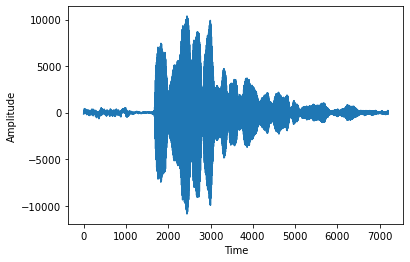




testing ./dataset/raw/wanted_beep_files/beep_with_whitenoise_clip_01_22K.wav
testFreq calculated:1699.5749062729496
diff_freq calculated:0
lenght of window:12609
length of fftData:513
Wanted Frequencey detected:1699.5749062729496Hz and magnitude: 2390.4097067218213



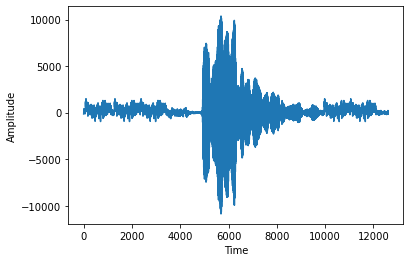




testing ./dataset/raw/similar_wanted_beep_files/similar_beep_04_clear_clip_01.wav
testFreq calculated:2434.0033158335345
diff_freq calculated:734
lenght of window:6751
length of fftData:513
wanted frequency:1700 is not found, found frequency:2434.0033158335345 and magnitude is 2689.802661977078


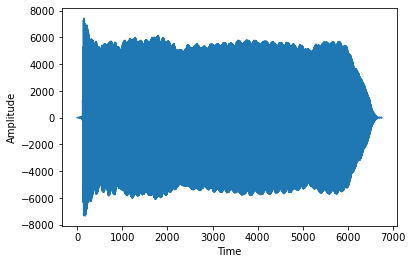




testing ./dataset/raw/neg_test_files/neg_beep_clear_clip_01_22K.wav
testFreq calculated:2034.9128564811258
diff_freq calculated:334
lenght of window:6368
length of fftData:513
wanted frequency:1700 is not found, found frequency:2034.9128564811258 and magnitude is 3710.6605515650876


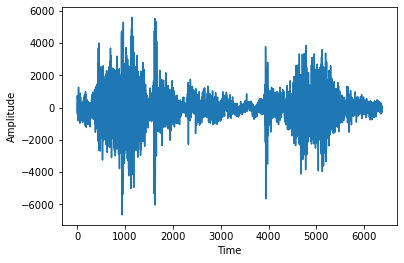




testing ./dataset/raw/neg_test_files/neg_beep_clear_clip_02_22K.wav
testFreq calculated:1152.652873795395
diff_freq calculated:547
lenght of window:19104
length of fftData:513
wanted frequency:1700 is not found, found frequency:1152.652873795395 and magnitude is 535.5228605310947


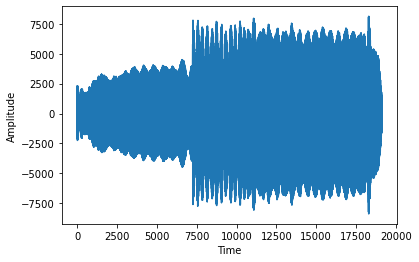




testing ./dataset/raw/neg_test_files/beep04_clear_clip_01_22K.wav
testFreq calculated:1000.0272216521424
diff_freq calculated:699
lenght of window:21735
length of fftData:513
wanted frequency:1700 is not found, found frequency:1000.0272216521424 and magnitude is 1530.9800717576009


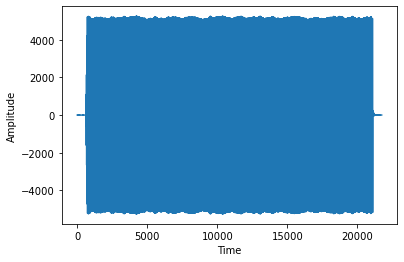




testing ./dataset/raw/similar_wanted_beep_files/similar_beep_01_clear_clip_01.wav
testFreq calculated:512.7619597504998
diff_freq calculated:1187
lenght of window:7420
length of fftData:513
wanted frequency:1700 is not found, found frequency:512.7619597504998 and magnitude is 1835.4227447451515


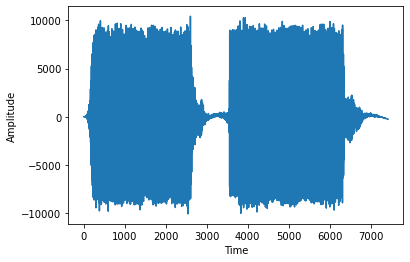

In [35]:
_freq_func = freq_estimate.freq_from_autocorr;
print(f"testing {test_beep1}")
detectAudio(signal=_beep_sig1, sr=_sr, wanted_freq=_wanted_beep_freq, magthreshold=_threshold, freqthreshold=_beepfreqthreshold, freq_func=_freq_func);
plot_wav(_beep_sig1);
IPython.display.display(Audio(_beep_sig1, rate=_sr))
print("\n\n");
print(f"testing {test_beep2}")
detectAudio(signal=_beep_sig2, sr=_sr, wanted_freq=_wanted_beep_freq, magthreshold=_threshold, freqthreshold=_beepfreqthreshold, freq_func=_freq_func);
plot_wav(_beep_sig2);
IPython.display.display(Audio(_beep_sig2, rate=_sr))
print("\n\n");
print(f"testing {test_beep5}");
detectAudio(signal=_beep_sig5, sr=_sr, wanted_freq=_wanted_beep_freq, magthreshold=_threshold, freqthreshold=_beepfreqthreshold, freq_func=_freq_func);
plot_wav(_beep_sig5);
IPython.display.display(Audio(_beep_sig5, rate=_sr))
print("\n\n");
print(f"testing {n_wav}");
detectAudio(signal=n_sig, sr=_sr, wanted_freq=_wanted_beep_freq, magthreshold=_threshold, freqthreshold=_beepfreqthreshold, freq_func=_freq_func);
plot_wav(n_sig);
IPython.display.display(Audio(n_sig, rate=_sr))
print("\n\n");
print(f"testing {n_wav2}");
detectAudio(signal=n_sig2, sr=_sr, wanted_freq=_wanted_beep_freq, magthreshold=_threshold, freqthreshold=_beepfreqthreshold, freq_func=_freq_func);
plot_wav(n_sig2);
IPython.display.display(Audio(n_sig2, rate=_sr))
print("\n\n");
print(f"testing {test_beep3}");
detectAudio(signal=_beep_sig3, sr=_sr, wanted_freq=_wanted_beep_freq, magthreshold=_threshold, freqthreshold=_beepfreqthreshold, freq_func=_freq_func);
plot_wav(_beep_sig3);
IPython.display.display(Audio(_beep_sig3, rate=_sr))
print("\n\n");
print(f"testing {test_beep4}");
detectAudio(signal=_beep_sig4, sr=_sr, wanted_freq=_wanted_beep_freq, magthreshold=_threshold, freqthreshold=_beepfreqthreshold, freq_func=_freq_func);
plot_wav(_beep_sig4);
IPython.display.display(Audio(_beep_sig4, rate=_sr))


In [26]:
"""
func processAudio(in []int32) {
	// Windowing function to the audio samples before performing the FFT.
	window := make([]float64, len(in))
	for i, x := range in {
		window[i] = float64(x) * (0.54 - 0.46*math.Cos(2*math.Pi*float64(i)/float64(len(in)-1)))
	}

	// Direct FFT
	// window := make([]float64, len(in))
	// for i, x := range in {
	// 	window[i] = float64(x)
	// }

	fftData := fft.FFTReal(window)

	// Find the magnitude of the target frequency bin
	targetIndex := int(float64(len(fftData)) * float64(*targetFreq) / float64(sampleRate))
	magnitude := cmplx.Abs(fftData[targetIndex])

	// Check if the magnitude is above the threshold
	if magnitude > threshold {
		go checkBeeps(true)
		// fmt.Printf("Significant data detected %dHz, magnitude: %.0f\n", targetFreq, magnitude)
	} else {
		go checkBeeps(false)
		// fmt.Printf("\rNo significant magnitude at %d Hz\n", targetFreq)
	}
}
"""

'\nfunc processAudio(in []int32) {\n\t// Windowing function to the audio samples before performing the FFT.\n\twindow := make([]float64, len(in))\n\tfor i, x := range in {\n\t\twindow[i] = float64(x) * (0.54 - 0.46*math.Cos(2*math.Pi*float64(i)/float64(len(in)-1)))\n\t}\n\n\t// Direct FFT\n\t// window := make([]float64, len(in))\n\t// for i, x := range in {\n\t// \twindow[i] = float64(x)\n\t// }\n\n\tfftData := fft.FFTReal(window)\n\n\t// Find the magnitude of the target frequency bin\n\ttargetIndex := int(float64(len(fftData)) * float64(*targetFreq) / float64(sampleRate))\n\tmagnitude := cmplx.Abs(fftData[targetIndex])\n\n\t// Check if the magnitude is above the threshold\n\tif magnitude > threshold {\n\t\tgo checkBeeps(true)\n\t\t// fmt.Printf("Significant data detected %dHz, magnitude: %.0f\n", targetFreq, magnitude)\n\t} else {\n\t\tgo checkBeeps(false)\n\t\t// fmt.Printf("\rNo significant magnitude at %d Hz\n", targetFreq)\n\t}\n}\n'